# Project 3: Web APIs & Classification

## Problem Statement

Given posts from two Using Reddit's API, you'll collect posts from two subreddits, r/worldnews and r/todayilearned, we will use NLP to train a classifier on which subreddit a given post came from.

## Executive Summary
Naive bayes was found to be more accurate at classifying titles into subreddits than the comparison model, basic decision tree.

### Contents:
- [Scraping reddit for data](#Scraping-reddit-for-data)
- [Explore and clean data](#Explore-and-clean-data)
- [Building model](#Building-model)
- [Building second model](#Building-second-model)
- [Conclusions and Recommendations](#Conclusions-and-Recommendations)

In [1]:
import numpy as np
import pandas as pd
import pleiades as ple
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
import data_plots as dp
from sklearn.naive_bayes import MultinomialNB

%matplotlib inline

## Import data

In [2]:
import_path = r'..\datasets\worldnews.csv'
data = pd.read_csv(import_path)

In [3]:
import_path = r'..\datasets\todayilearned.csv'
data2 = pd.read_csv(import_path)

## Explore and clean data

In [4]:
data3 = pd.concat([data, data2], join='inner', ignore_index=True)

In [5]:
export_path = r'..\datasets\reddit.csv'
data3.to_csv(export_path)

In [6]:
data3.head()

,approved_at_utc,subreddit,selftext,author_fullname,saved,mod_reason_title,gilded,clicked,title,link_flair_richtext,...,parent_whitelist_status,stickied,url,subreddit_subscribers,created_utc,num_crossposts,media,is_video,link_flair_template_id,author_cakeday
0,NaN,worldnews,NaN,t2_4p0y4poi,False,NaN,0,False,Greta Thunberg arrives in Lisbon today for UNc...,[],...,all_ads,False,https://www.cbsnews.com/news/greta-thunberg-ar...,22599869,1.575409e+09,5,NaN,False,NaN,NaN
1,NaN,worldnews,NaN,t2_2yqt,False,NaN,0,False,"'So If You're Poor, You're Dead'? Watch These ...",[],...,all_ads,False,https://www.commondreams.org/news/2019/12/03/s...,22599869,1.575393e+09,8,NaN,False,NaN,NaN
2,NaN,worldnews,NaN,t2_2nmahwux,False,NaN,1,False,US Navy ‘invited’ to go to Taiwan and ‘have fu...,[],...,all_ads,False,https://www.scmp.com/news/china/military/artic...,22599869,1.575393e+09,3,NaN,False,NaN,NaN
3,NaN,worldnews,NaN,t2_etf58,False,NaN,0,False,Trump Impeachment Report Released by House Panel,[],...,all_ads,False,https://www.nytimes.com/2019/12/03/us/politics...,22599869,1.575400e+09,1,NaN,False,9ce4c7a8-dd0c-11e6-a0a7-0e5f1a4285f8,NaN
4,NaN,worldnews,NaN,t2_4g3lx,False,NaN,0,False,France's president just fact-checked Trump in ...,[],...,all_ads,False,https://www.cnn.com/politics/live-news/nato-su...,22599869,1.575388e+09,1,NaN,False,NaN,NaN


In [7]:
df = data3[['title', 'subreddit']]

X = df['title']
y = df['subreddit'].values

#### Remove unwanted characters.

TIL is removed here as it makes the model overfit.

In [8]:
reddit_lingo = {
    'TIL': '',
    '[tT]oday [iI] [lL]earned': '',
    'ff+uu+': 'ffuuu'
}

In [9]:
cz = ple.CZ()
print('before:', X[1])
X = cz.text_cleaner(X, cz.contractions, reddit_lingo,
                    r'[^a-zA-Z ]', cz.lemmatize_sentence)
print('after:', X[1])

before: 'So If You're Poor, You're Dead'? Watch These Brits Gasp When They Find Out Cost of Healthcare in the United States
after: so if you are poor you are dead watch these brit gasp when they find out cost of healthcare in the united state


## Building model

In [36]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=1, stratify=y)

#### Tuning hyperparameters

In [11]:
pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('nb', MultinomialNB())
])
params = {
    'tvec__stop_words': [None, 'english'],
    'tvec__ngram_range': [(1, 1), (1, 2)],
    'tvec__max_df': [.85, .9, .95],
    'tvec__min_df': [2, 4, 6],
    'tvec__max_features': [1000, 2000, 3000],
}
gs = GridSearchCV(pipe, param_grid=params, cv=5, n_jobs=-1)
gs.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('tvec',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                          

In [12]:
print('best score:', gs.best_score_)

best score: 0.9316081330868762


In [13]:
print('best params:', gs.best_params_)

best params: {'tvec__max_df': 0.85, 'tvec__max_features': 3000, 'tvec__min_df': 2, 'tvec__ngram_range': (1, 1), 'tvec__stop_words': None}


In [37]:
tvec = TfidfVectorizer(stop_words=None, ngram_range=(
    1, 1), max_df=0.85, min_df=2, max_features=3000)
X_train_tvec = tvec.fit_transform(X_train)
X_train_tvec = pd.DataFrame(X_train_tvec.toarray(),
                            columns=tvec.get_feature_names())
X_test_tvec = tvec.transform(X_test)
X_test_tvec = pd.DataFrame(X_test_tvec.toarray(),
                           columns=tvec.get_feature_names())
print('TfidfVectorizer:')
print(X_train_tvec.sum().sort_values(ascending=False)[:5])
print()

TfidfVectorizer:
the    79.602298
in     53.098323
to     52.975444
of     52.868069
and    38.739198
dtype: float64



In [38]:
nb = MultinomialNB()

In [39]:
nb.fit(X_train_tvec, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [40]:
y_pred = nb.predict(X_test_tvec)

In [41]:
print('model accuracy on itself:', nb.score(X_train_tvec, y_train))
print('model accuracy on test set:', nb.score(X_test_tvec, y_test))

model accuracy on itself: 0.9870609981515711
model accuracy on test set: 0.9307479224376731


#### Plot ROC

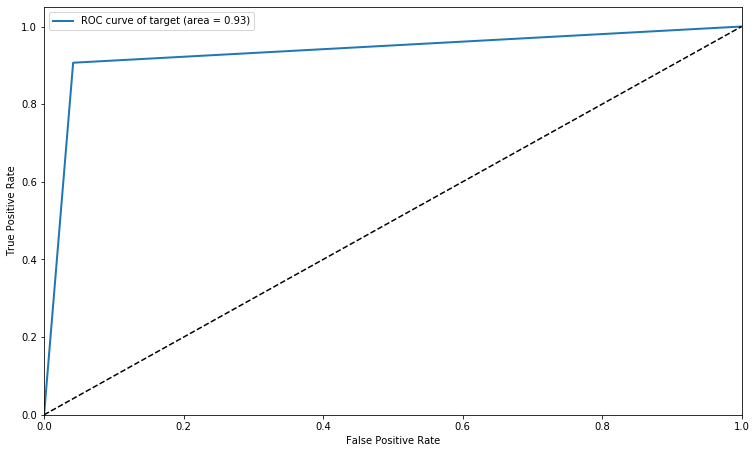

In [42]:
roc = dp.Roc()
roc.plot(y_test, y_pred, figsize=(12.5, 7.5))

## Building second model

#### Tuning hyperparameters

In [43]:
pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('dt', DecisionTreeClassifier())
])
params = {
    'tvec__stop_words': [None, 'english'],
    'tvec__ngram_range': [(1, 1), (1, 2)],
    'tvec__max_df': [.85, .9, .95],
    'tvec__min_df': [2, 4, 6],
    'tvec__max_features': [1000, 2000, 3000],
}
gs = GridSearchCV(pipe, param_grid=params, cv=5, n_jobs=-1)
gs.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('tvec',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                          

In [44]:
print('best score:', gs.best_score_)

best score: 0.8724584103512015


In [45]:
def get_params(dict):
    from re import match
    params = {}
    pattern = r'^([a-zA-Z0-9_]+)__([a-zA-Z0-9_]+)'
    for k, v in dict.items():
        if isinstance(v, str):
            v = "'" + v + "'"
        m = match(pattern, k)
        key = m.group(1)
        kwarg = f'{m.group(2)}={v}'
        if key in params:
            params[key].append(kwarg)
        else:
            params[key] = [kwarg]
    for k, v in params.items():
        joined_list = ', '.join(map(str, v))
        return f'{k}: {joined_list}'

In [46]:
print('best params:', get_params(gs.best_params_))

best params: tvec: max_df=0.85, max_features=2000, min_df=6, ngram_range=(1, 2), stop_words=None


In [47]:
tvec = TfidfVectorizer(max_df=0.85, max_features=2000, min_df=6, ngram_range=(1, 2), stop_words=None)
X_train = tvec.fit_transform(X_train)
X_train = pd.DataFrame(X_train.toarray(), columns=tvec.get_feature_names())
X_test = tvec.transform(X_test)
X_test = pd.DataFrame(X_test.toarray(), columns=tvec.get_feature_names())
print('TfidfVectorizer:')
print(X_train.sum().sort_values(ascending=False)[:5])

TfidfVectorizer:
the    100.438864
in      71.318543
to      70.025311
of      68.708187
and     50.637057
dtype: float64


#### Visualize impact of decision tree hyperparameters.

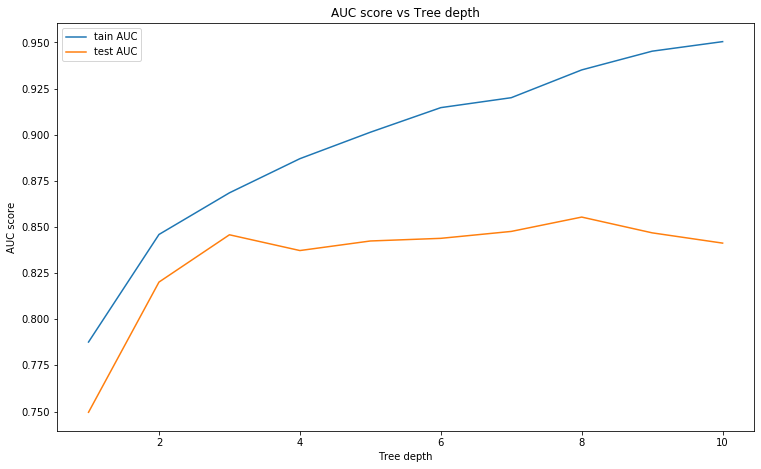

In [48]:
max_depths = np.linspace(1, 10, 10)
roc = dp.Roc()
auc_scores = roc.dt_auc_scores(X_train, X_test, y_train, y_test, {'max_depth': max_depths})
roc.plot_auc(max_depths, auc_scores, title='AUC score vs Tree depth',
             xlabel='Tree depth', labels=['tain AUC', 'test AUC'], figsize=(12.5, 7.5))

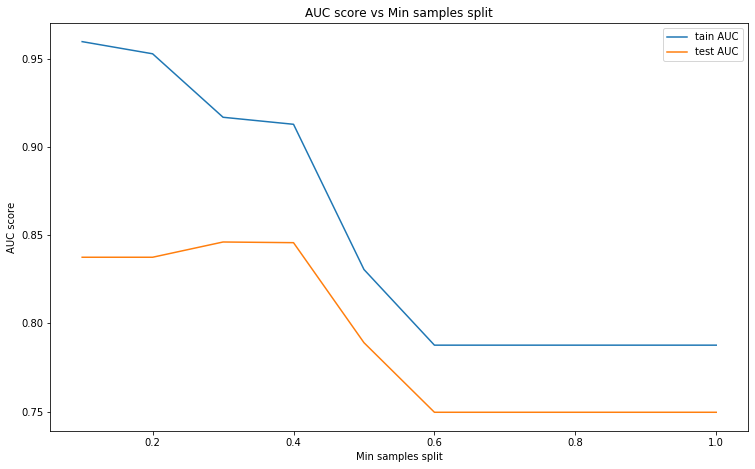

In [49]:
min_samples_splits = np.linspace(0.1, 1.0, 10, endpoint=True)
auc_scores = roc.dt_auc_scores(X_train, X_test, y_train, y_test, {
                               'min_samples_split': min_samples_splits})
roc.plot_auc(min_samples_splits, auc_scores, title='AUC score vs Min samples split',
             xlabel='Min samples split', labels=['tain AUC', 'test AUC'], figsize=(12.5, 7.5))

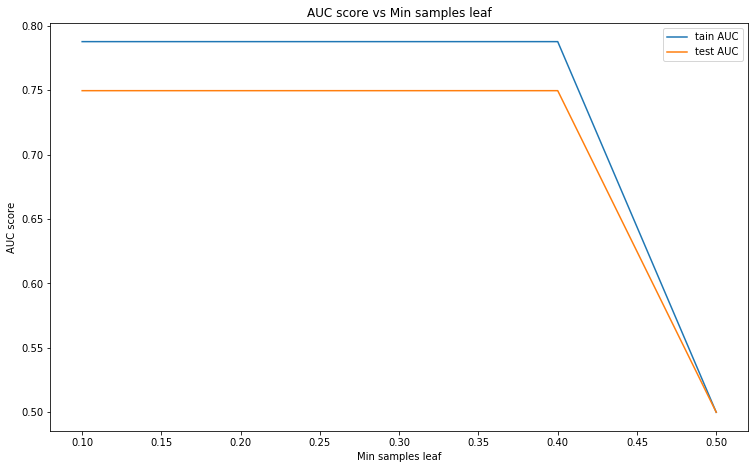

In [50]:
min_samples_leafs = np.linspace(0.1, 0.5, 5, endpoint=True)
auc_scores = roc.dt_auc_scores(X_train, X_test, y_train, y_test, {
                               'min_samples_leaf': min_samples_leafs})
roc.plot_auc(min_samples_leafs, auc_scores, title='AUC score vs Min samples leaf',
             xlabel='Min samples leaf', labels=['tain AUC', 'test AUC'], figsize=(12.5, 7.5))

In [51]:
dt = DecisionTreeClassifier()
params = {
    'max_depth': [3, 4, 5],
    'min_samples_split': [0.2, 0.3, 0.4],
    'min_samples_leaf': [0.05, 0.1, 0.15]
}
gs = GridSearchCV(dt, param_grid=params, cv=5, n_jobs=-1)
gs.fit(X_train, y_train)

print('best score:', gs.best_score_)
print('best params:', gs.best_params_)

best score: 0.8207024029574861
best params: {'max_depth': 3, 'min_samples_leaf': 0.05, 'min_samples_split': 0.2}


#### Plot ROC

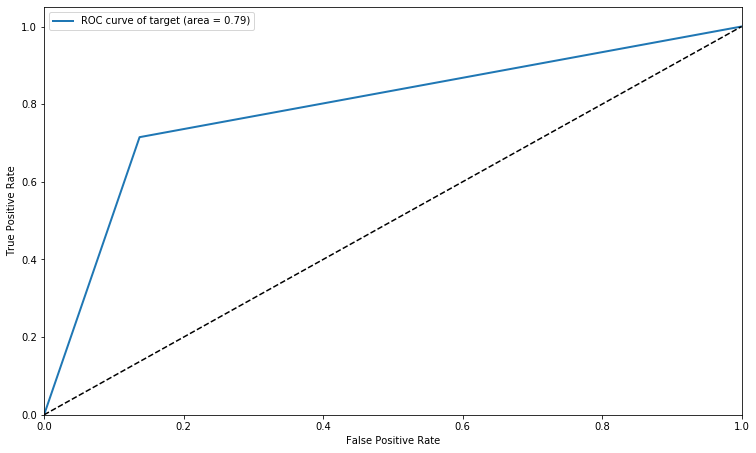

In [52]:
y_pred = gs.predict(X_test)

roc.plot(y_test, y_pred, figsize=(12.5, 7.5))

## Conclusions and Recommendations

I found the simple naive bayes to produce better results than a single decision tree. Some of the findings were suprising, for instance, the fact that removal of stopwords reduced the accuracy of the model.

#### Model weaknesses

The dataset of that the model is trained is likely not representative of the content of the subreddit in the long run. This is because a subreddit like r/worldnews changes with current news and events. As such, there needs to be a way for the model to recognize the type of content in the subreddit apart from individual words.

The single decision tree model used as comparison with simple naive bayes comes with many variations. In the process of building the model I found that the accuracy of the model varied substantially. An emsemble approach such as bagged trees or random forest may produce better results.